# Tutorial 5.1: Inception, ResNet and DenseNet

In this tutorial, we will implement and discuss variants of modern CNN architectures. There have been many different architectures been proposed over the past few years. Some of the most impactful ones, and still relevant today, are the following: GoogleNet/Inception architecture (winner of ILSVRC 2014), ResNet (winner of ILSVRC 2015), and DenseNet (best paper award CVPR 2017). All of them were state-of-the-art models when being proposed, and the core ideas of these networks are the foundations for most current state-of-the-art architectures. Thus, it is important to understand these architectures in detail, and learn how to implement them. 

Let's start with importing our standard libraries here.

In [1]:
USE_NOTEBOOK = True
TEST_NOTEBOOK = False
TRAIN_GOOGLENET = True
TRAIN_RESNET = True
TRAIN_DENSENET = True

## Standard libraries
import os
import json
import math
import numpy as np 
import scipy.linalg
import random
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
if USE_NOTEBOOK:
    %matplotlib inline 
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('svg', 'pdf') # For export
    from matplotlib.colors import to_rgb
    import matplotlib
    matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial5"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Throughout this tutorial, we will train and evaluate the models on the CIFAR10 dataset. This allows you to compare the results obtained here with the model you have implemented in the first assignment. As we have learned from the previous tutorial about initialization, it is important to have the data preprocessed with a zero mean. Therefore, as a first step, we will calculate the mean and standard deviation of the CIFAR dataset:

In [3]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


We will use this information to define a `transforms.Normalize` module which will normalize our data accordingly. Additionally, we will use data augmentation during training. This reduces the risk of overfitting, and helps CNNs to generalize better. Specifically, we will apply two random augmentations. 

First, we will flip each image horizontally by a chance of 50% (`transforms.RandomHorizontalFlip`). The object class usually does not change when flipping an image, and we don't expect any image information to be dependent on the horizontal orientation. This would be however different if we would try to detect digits or letters in an image, as those have a certain orientation.

The second augmentation we use is called `transforms.RandomResizedCrop`. This transformation scales the image in a small range, while eventually changing the aspect ratio, and crops it afterwards in the previous size. Therefore, the actual pixel values change while the content or overall semantics of the image stay the same. 

We will randomly split the training dataset into a training and a validation set. The validation set will be used for determining early stopping. After finishing the training, we test the models on the CIFAR test set.

In [4]:
# Transformations applied on each image => make them a tensor and normalize
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


To verify that our normalization works, we can print out the mean and standard deviation of the single batch. The mean should be close to 0 and the standard deviation close to 1 for each channel:

In [5]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([-0.0143, -0.0204, -0.0017])
Batch std tensor([0.9772, 0.9650, 0.9809])


Finally, let's visualize a few images from the training set, and how they look like after random data augmentation: 

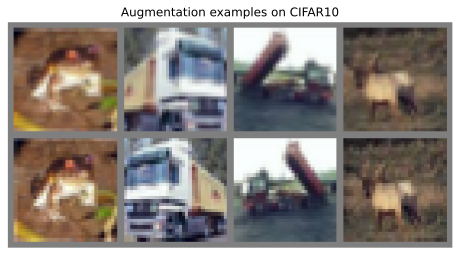

In [6]:
if USE_NOTEBOOK:
    NUM_IMAGES = 4
    images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
    orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
    orig_images = [test_transform(img) for img in orig_images]

    img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(8,8))
    plt.title("Augmentation examples on CIFAR10")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

## PyTorch Lightning

In this notebook and in many following ones, we will make use of the library [PyTorch Lightning](https://www.pytorchlightning.ai/). PyTorch Lightning is a framework that simplifies your code needed to train, evaluate and test a model in PyTorch. It also handles logging into tensorboard and saving model checkpoints automatically with minimal code overhead from our side. This is extremely helpful for us as we want to focus on implementing different model architectures, and spend little time on other code overhead. Note that at the time of writing/teaching, the framework has been released in version 1.0. Future versions might have a slightly changed interface, and thus might not work perfectly with the code (we will try to keep it up-to-date as much as possible). 

Now, we will take the first step in PyTorch Lightning, and continue to explore the framework in our other tutorials. First, we import the library:

In [7]:
# PyTorch Lightning
import pytorch_lightning as pl

PyTorch Lightning comes with a lot of useful functions, such as one for setting the seed:

In [8]:
# Setting the seed
pl.seed_everything(42)

42

Thus, in future, we don't have to define our own `set_seed` function anymore. 

In PyTorch Lightning, we define `pl.LightningModule`'s (inherting from `torch.nn.Module`) that organize our code into 5 main sections: 
1. Initialization (`__init__`), where we create all necessary parameters/models
2. Optimizers (`configure_optimizers`) where we create the optimizers, learning rate scheduler etc. 
3. Training loop (`training_step`) where we only have to define the loss calculation for a single batch (the loop of optimizer.zero_grad(), loss.backward() and optimizer.step() as well as any logging/saving operation is done in the background)
4. Validation loop (`validation_step`) where similarly to the training, we only have to define what should happen per step
5. Test loop (`test_step`) which is the same as validation, only on a test set.

Therefore, we don't abstract the PyTorch code, but rather organize it and define some default operations that are commonly used. If you need to change something else in your training/validation/test loop, there are many possible functions you can overwrite (see the [docs](https://pytorch-lightning.readthedocs.io/en/stable/lightning_module.html) for details).

Now we can look at an example of how a Lightning Module for training a CNN looks like:

In [9]:
class CIFARTrainer(pl.LightningModule):
    
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)
    
    
    def forward(self, imgs):
        # Forward function that is run when visualizing the graph
        return self.model(imgs)
    
    
    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, "Unknown optimizer: \"%s\"" % self.hparams.optimizer_name
        
        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [scheduler]
    
    
    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader. 
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        self.log('train_acc', acc, on_step=False, on_epoch=True) # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_loss', loss)
        return loss # Return tensor to call ".backward" on
    
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log('val_acc', acc) # By default logs it per epoch (weighted average over batches)
        
        
    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log('test_acc', acc) # By default logs it per epoch (weighted average over batches), and returns it afterwards

We see that the code is organized and clear, which helps if someone else tries to understand your code. 

Another important part of PyTorch Lightning are callbacks. Callbacks are self-contained functions that contain non-essential logic of your Lightning Module. They are usually called after finishing a training epoch, but can also influence other parts of your training loop. For instance, we will use the following two pre-defined callbacks: `LearningRateMonitor` and `ModelCheckpoint`. The learning rate monitor adds the current learning rate to our tensorboard, which helps to verify that our learning rate scheduler works correctly. The model checkpoint callback allows you to customize the saving routine of your checkpoints. For instance, how many checkpoints to keep, when to save, which metric to look out for, etc. We import them below:

In [10]:
# Callbacks 
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

To allow running multiple different models with the same Lightning module, we define a function below that maps a model name to the model class. At this stage, the dictionary `model_dict` is empty, but we will fill throughout the notebook with our new models.

In [11]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, "Unknown model name \"%s\". Available models are: %s" % (model_name, str(model_dict.keys()))

Similarly, to use the activation function as another hyperparameter in our model, we define a "name to function" dict below:

In [12]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

If we pass the classes or objects directly as argument to the Lightning module, we couldn't take advantage of PyTorch Lightning's automatically hyperparameter saving and loading.

Besides the Lightning module, the second most important module in PyTorch Lightning is the `Trainer`. The trainer is responsible to execute the training steps defined in the Lightning module, and completes the framework. Similar to the Lightning module, you can override any key part that you don't want automated, but the default settings are often the best practice to do. For a full overview, see the [documentation](https://pytorch-lightning.readthedocs.io/en/stable/trainer.html). The most important functions we use below are:
* `trainer.fit`: Takes as input a lightning module, a training dataset and a (optional) validation dataset. This function trains the given module on the training dataset with occasional validation (default once per epoch, can be changed)
* `trainer.test`: Takes as input a model and a dataset on which we want to test. It returns the test metric on the dataset.

For training and testing, we don't have to worry about things like setting the model to eval mode (`model.eval()`) as this is all done automatically. See below how we define a training function for our models:

In [13]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name
        
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                                  # Where to save models
                         checkpoint_callback=ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"), # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                         gpus=1 if str(device)=="cuda:0" else 0,                                                     # We run on a single GPU (if possible)
                         max_epochs=180 if not TEST_NOTEBOOK else 1,                                                 # How many epochs to train for if no patience is set
                         callbacks=[LearningRateMonitor("epoch")],                                                   # Log learning rate every epoch
                         progress_bar_refresh_rate=0 if not USE_NOTEBOOK else 1)                                     # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = CIFARTrainer.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARTrainer(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        
    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    
    return model, result

## Inception

[GoogleNet](https://arxiv.org/abs/1409.4842)

<img src="inception_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="50%"/>

In [14]:
class InceptionBlock(nn.Module):
    
    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        super().__init__()
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )
        
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )
        
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )
        
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )
        
    
    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

In [15]:
class GoogleNet(nn.Module):
    
    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = {"num_classes": num_classes, 
                        "act_fn_name": act_fn_name, 
                        "act_fn": act_fn_by_name[act_fn_name]}
        self._create_network()
        self._init_params()
    
    
    def _create_network(self):
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams["act_fn"]()
        )
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3":32,"5x5":16}, c_out={"1x1":16,"3x3":32,"5x5":8,"max":8}, act_fn=self.hparams["act_fn"]),
            InceptionBlock(64, c_red={"3x3":32,"5x5":16}, c_out={"1x1":24,"3x3":48,"5x5":12,"max":12}, act_fn=self.hparams["act_fn"]),
            nn.MaxPool2d(3, stride=2, padding=1),
            InceptionBlock(96, c_red={"3x3":32,"5x5":16}, c_out={"1x1":24,"3x3":48,"5x5":12,"max":12}, act_fn=self.hparams["act_fn"]),
            InceptionBlock(96, c_red={"3x3":32,"5x5":16}, c_out={"1x1":16,"3x3":48,"5x5":16,"max":16}, act_fn=self.hparams["act_fn"]),
            InceptionBlock(96, c_red={"3x3":32,"5x5":16}, c_out={"1x1":16,"3x3":48,"5x5":16,"max":16}, act_fn=self.hparams["act_fn"]),
            InceptionBlock(96, c_red={"3x3":32,"5x5":16}, c_out={"1x1":32,"3x3":48,"5x5":24,"max":24}, act_fn=self.hparams["act_fn"]),
            nn.MaxPool2d(3, stride=2, padding=1),
            InceptionBlock(128, c_red={"3x3":48,"5x5":16}, c_out={"1x1":32,"3x3":64,"5x5":16,"max":16}, act_fn=self.hparams["act_fn"]),
            InceptionBlock(128, c_red={"3x3":48,"5x5":16}, c_out={"1x1":32,"3x3":64,"5x5":16,"max":16}, act_fn=self.hparams["act_fn"])
        )
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams["num_classes"])
        )
        
    
    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams["act_fn_name"])
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    
    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [16]:
model_dict["GoogleNet"] = GoogleNet

In [17]:
if TRAIN_GOOGLENET:
    googlenet_model, googlenet_results = train_model(model_name="GoogleNet", 
                                                     model_hparams={"num_classes": 10, 
                                                                    "act_fn_name": "relu"}, 
                                                     optimizer_name="Adam",
                                                     optimizer_hparams={"lr": 1e-3,
                                                                        "weight_decay": 1e-4})
else:
    googlenet_results = {}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model at ../saved_models/tutorial5/GoogleNet.ckpt, loading...


In [18]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'test': 0.9071000218391418, 'val': 0.9064000248908997}


## ResNet

[ResNet](https://arxiv.org/abs/1512.03385), [Pre-Activation ResNet](https://arxiv.org/abs/1603.05027)

<img src="resnet_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="30%"/>

In [50]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        super().__init__()
        if not subsample:
            c_out = c_in
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out)
        )
        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

        
    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        z = z + x
        out = self.act_fn(z)
        return out

In [51]:
class PreActResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        super().__init__()
        if not subsample:
            c_out = c_in
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1 if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False)
        )
        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
        ) if subsample else None
        self.act_fn = act_fn()

        
    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        out = z + x
        return out

In [52]:
resnet_blocks_by_name = {
    "ResNetBlock": ResNetBlock,
    "PreActResNetBlock": PreActResNetBlock
}

In [53]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, c_hidden=[16,32,64], num_blocks=[3,3,3], act_fn_name="relu", block_name="ResNetBlock", **kwargs):
        super().__init__()
        assert block_name in resnet_blocks_by_name
        self.hparams = {"num_classes": num_classes, 
                        "c_hidden": c_hidden, 
                        "num_blocks": num_blocks, 
                        "act_fn_name": act_fn_name,
                        "act_fn": act_fn_by_name[act_fn_name],
                        "block_class": resnet_blocks_by_name[block_name]}
        self._create_network()
        self._init_params()

        
    def _create_network(self):
        c_hidden = self.hparams["c_hidden"]
        if self.hparams["block_class"] == PreActResNetBlock:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1)
            )
        else:
            self.input_net = nn.Sequential(
                nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1),
                nn.BatchNorm2d(c_hidden[0]),
                self.hparams["act_fn"]()
            )
        blocks = []
        for block_idx, block_count in enumerate(self.hparams["num_blocks"]):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0)
                blocks.append(
                    self.hparams["block_class"](c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                                act_fn=self.hparams["act_fn"],
                                                subsample=subsample,
                                                c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams["num_classes"])
        )
        
    
    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.hparams["act_fn_name"])
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        
    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [54]:
model_dict["ResNet"] = ResNet

In [55]:
if TRAIN_RESNET:
    resnet_model, resnet_results = train_model(model_name="ResNet", 
                                               model_hparams={"num_classes": 10,
                                                              "c_hidden": [16,32,64],
                                                              "num_blocks": [3,3,3],
                                                              "act_fn_name": "relu"}, 
                                               optimizer_name="SGD",
                                               optimizer_hparams={"lr": 0.1,
                                                                  "momentum": 0.9,
                                                                  "weight_decay": 1e-4})
else:
    resnet_results = {}

GPU available: True, used: True
I1014 21:33:22.247854 139989529995072 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1014 21:33:22.249960 139989529995072 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1014 21:33:22.251427 139989529995072 accelerator_connector.py:385] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


In [56]:
print("ResNet results", resnet_results)

ResNet results {'test': 0.9083999991416931, 'val': 0.9150000214576721}


In [57]:
if TRAIN_RESNET:
    resnet_model, resnet_results = train_model(model_name="ResNet", 
                                               model_hparams={"num_classes": 10,
                                                              "c_hidden": [16,32,64],
                                                              "num_blocks": [3,3,3],
                                                              "act_fn_name": "relu",
                                                              "block_name": "PreActResNetBlock"}, 
                                               optimizer_name="SGD",
                                               optimizer_hparams={"lr": 0.1,
                                                                  "momentum": 0.9,
                                                                  "weight_decay": 1e-4},
                                               save_name="ResNetPreAct")
else:
    resnet_results = {}

GPU available: True, used: True
I1014 21:33:26.638688 139989529995072 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1014 21:33:26.640810 139989529995072 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1014 21:33:26.642202 139989529995072 accelerator_connector.py:385] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


In [58]:
print("PreActResnet results", resnet_results)

PreActResnet results {'test': 0.911899983882904, 'val': 0.9182000160217285}


## DenseNet

[DenseNet](https://arxiv.org/abs/1608.06993)

<img src="densenet_block.svg" style="display: block; margin-left: auto; margin-right: auto;" width="50%"/>

In [59]:
class DenseLayer(nn.Module):
    
    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
            bn_size - Bottleneck size (factor of growth rate)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

In [60]:
class DenseBlock(nn.Module):
    
    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                DenseLayer(c_in=c_in + layer_idx * growth_rate,
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn)
            )
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.block(x)
        return out

In [61]:
class ReductionLayer(nn.Module):
    
    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.reduction = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        return self.reduction(x)

In [62]:
class DenseNet(nn.Module):
    
    def __init__(self, num_classes=10, num_layers=[6,6,6,6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = {"num_classes": num_classes,
                        "num_layers": num_layers,
                        "bn_size": bn_size,
                        "growth_rate": growth_rate,
                        "act_fn_name": act_fn_name,
                        "act_fn": act_fn_by_name[act_fn_name]}
        self._create_network()
        self._init_params()
        
    def _create_network(self):
        c_hidden = self.hparams["growth_rate"] * self.hparams["bn_size"]
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams["num_layers"]):
            blocks.append( 
                DenseBlock(c_in=c_hidden, 
                           num_layers=num_layers, 
                           bn_size=self.hparams["bn_size"],
                           growth_rate=self.hparams["growth_rate"],
                           act_fn=self.hparams["act_fn"])
            )
            c_hidden = c_hidden + num_layers * self.hparams["growth_rate"]
            if block_idx < len(self.hparams["num_layers"])-1:
                blocks.append(
                    ReductionLayer(c_in=c_hidden,
                                   c_out=c_hidden // 2,
                                   act_fn=self.hparams["act_fn"]))
                c_hidden = c_hidden // 2
                
        self.blocks = nn.Sequential(*blocks)
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden),
            self.hparams["act_fn"](),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams["num_classes"])
        )
        
    
    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams["act_fn_name"])
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
        
        
    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

In [63]:
model_dict["DenseNet"] = DenseNet

In [64]:
if TRAIN_DENSENET:
    densenet_model, densenet_results = train_model(model_name="DenseNet", 
                                                   model_hparams={"num_classes": 10,
                                                                  "num_layers": [6,6,6,6],
                                                                  "bn_size": 2,
                                                                  "growth_rate": 16,
                                                                  "act_fn_name": "relu"}, 
                                                   # optimizer_name="Adam",
                                                   # optimizer_hparams={"lr": 1e-3,
                                                   #                    "weight_decay": 1e-4}
                                                   optimizer_name="SGD",
                                                   optimizer_hparams={"lr": 0.1,
                                                                      "weight_decay": 1e-4})
else:
    densenet_results = {}

GPU available: True, used: True
I1014 21:33:32.984902 139989529995072 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1014 21:33:32.987139 139989529995072 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1014 21:33:32.988718 139989529995072 accelerator_connector.py:385] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


In [65]:
print(densenet_results)

{'test': 0.902999997138977, 'val': 0.9083999991416931}


### Visualize filters

(not helpful for 3x3 filters)

In [25]:
def visualize_filters(filter_weight, num_cols=8):
    if filter_weight.shape[1] > 3:
        print("Please provide a filter with less than 3 input channels")
    num_filters = filter_weight.shape[0]
    num_rows = int(math.ceil(num_filters/num_cols))
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*1.5, num_rows*1.5))
    
    filter_weight = filter_weight / filter_weight.abs().max()
    filter_weight = (filter_weight + 1) / 2
    filter_weight = filter_weight.permute(0, 2, 3, 1).cpu().numpy() # [Output channel, H, W, C]
    for r in range(num_rows):
        for c in range(num_cols):
            idx = r * num_cols + c
            axs[r][c].imshow(filter_weight[idx])
            axs[r][c].axis('off')
    plt.show()

In [26]:
def visualize_filters(filter_weight):
    num_filters = filter_weight.shape[0]
    num_rows = num_filters
    num_cols = filter_weight.shape[1]
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*2, num_rows*1.5))
    
    filter_weight = filter_weight / filter_weight.abs().max(dim=2, keepdim=True).values.max(dim=3, keepdim=True).values
    filter_weight = (filter_weight + 1) / 2
    filter_weight = filter_weight.permute(0, 2, 3, 1).cpu().numpy() # [Output channel, H, W, C]
    for r in range(num_rows):
        for c in range(num_cols):
            if num_cols == 3 and r == 0:
                axs[r][c].set_title(["Red channel", "Green channel", "Blue channel"][c])
            axs[r][c].imshow(filter_weight[r,:,:,c], cmap="gray")
            axs[r][c].axis('off')
    plt.show()

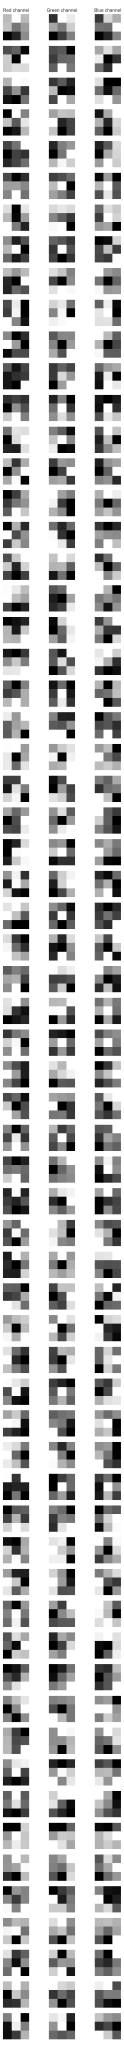

In [27]:
input_weights = googlenet_model.model.input_net[0].weight.detach()
# visualize_filters(input_weights)

### Visualize feature maps

In [109]:
img_mu = torch.Tensor(DATA_MEANS).view(1,3,1,1).to(device)
img_std = torch.Tensor(DATA_STD).view(1,3,1,1).to(device)

def visualize_feature_map(model, layer_idx, feature_map_idx, num_steps=100, step_size=1.0, return_img=True):
    img = torch.rand(1, 3, 32, 32).to(device) - 0.5
    img.requires_grad = True
    
    # Maximize average activation of feature map.
    model.eval()
    for p in model.parameters():
        p.requires_grad_(False)
    
    optimizer = optim.Adam([img], lr=0.1, weight_decay=1e-4)
    for _ in range(num_steps):
        feats = ((img + 1) / 2.0 - img_mu) / img_std
        feats = model.input_net(feats)
        for l in range(layer_idx):
            feats = model.inception_blocks[l](feats)
        feature_map = feats[:,feature_map_idx]
        feat_mean = feature_map.mean()
        
        optimizer.zero_grad()
        (-feat_mean).backward()
        optimizer.step()
        img.data.clamp_(min=-1.0, max=1.0)
        
    for p in model.parameters():
        p.requires_grad_(True)
        
    
    visu = img.detach().squeeze(dim=0).permute(1,2,0)
    visu = (visu + 1) / 2
    visu = visu.cpu().numpy()
    plt.title("Layer %i, Feature map %i" % (layer_idx, feature_map_idx))
    plt.imshow(visu)
    plt.axis('off')
    plt.show()
    plt.close()
    

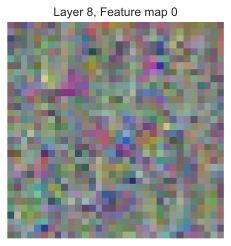

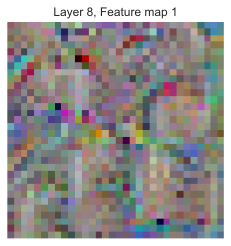

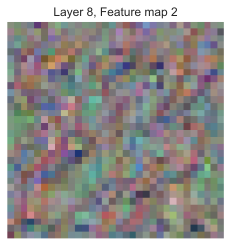

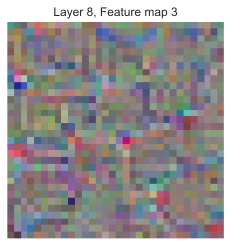

In [110]:
for i in range(4):
    visualize_feature_map(googlenet_model.model, layer_idx=8, feature_map_idx=i)